# Electricity emissions calculation 
## based on DA RFNBO Jan 2023

This notebook aims at providing some details on the calculation of the electricity emissions based on DA RFNBO Jan 2023.

This code uses Eurostat for EU countries data. With slight modifications in the data preparation, this code can also be used with IEA data (available from the [energy statistics data browser](https://www.iea.org/data-and-statistics/data-tools/energy-statistics-data-browser?country=GERMANY&energy=Coal&year=2020))

The Eurostat source data can be accessed directly:
- [here](https://ec.europa.eu/eurostat/databrowser/view/NRG_BAL_C__custom_3055577/default/table?lang=en), 
- by using the Eurostat API (but the amount of data per request that can be downloaded is limited),
- by downloading the full dataset [here](https://ec.europa.eu/eurostat/web/energy/data/database).

Useful explanation of the flows and their definition can be accessed [here](https://ec.europa.eu/eurostat/documents/38154/4956218/Energy-Balance-Formulas.xlsx/cc2f9ade-5c0b-47b5-b83d-c05fe86eef6c).

### Scope and definition of RFNBO carbon intensity:

The carbon footprint of RFNBO (Renewable Fuel of Non Biological Origin) is calculated considering the following points:
- In the case of Combined Heat and Power (CHP), the fuels used for heat produced in CHP shall be counted by considering alternative heat production with average overall efficiencies of 85%, while the rest shall be attributed to electricity generation.
- No fuels are associated with electricity production from renewables that include hydro, solar, wind and geothermal.
- The emissions from the construction and decommissioning and waste management of electricity producing facilities are not considered. Thus, the carbon equivalent emissions associated with the renewable electricity (wind, solar, hydro and geothermal) production are considered to be equal to zero.
- The CO<sub>2</sub> equivalent emissions from gross electricity production should include upstream emissions from JEC WTW v5 (Prussi et all, 2020) listed in Table 3 of the DA and the default emission factors for stationary combustion from IPCC Guidelines for National Greenhouse Gas Inventories (IPCC 2006) listed in Tables 1 and 2. The upstream emissions for supplying the fuel used are the JEC WTW v5 upstream emission factors (Prussi et all, 2020).

The calculation of the carbon intensity of electricity shall be done following the formula:

$𝑒_{𝑔𝑟𝑜𝑠𝑠\ 𝑝𝑟𝑜𝑑} = \sum_{i=1}^k (𝑐_{𝑢𝑝𝑠, i} + 𝑐_{𝑐𝑜𝑚𝑏, i}) ∗ 𝐵_𝑖 $

where: 
- $𝑒_{𝑔𝑟𝑜𝑠𝑠\ 𝑝𝑟𝑜𝑑}$ – CO<sub>2</sub> equivalent emissions [𝑔CO<sub>2</sub>𝑒𝑞]
- $𝑐_{𝑢𝑝𝑠, i}$ – upstream CO<sub>2</sub> equivalent emission factors [𝑔CO<sub>2</sub>𝑒𝑞/𝑀𝐽]
- $𝑐_{𝑐𝑜𝑚𝑏, i}$ – CO<sub>2</sub> equivalent emission factors from fuels combustion [𝑔CO<sub>2</sub>𝑒𝑞/𝑀𝐽]
- $𝐵_𝑖$ – fuel consumption for electricity generation [𝑀𝐽]
- $ 𝑖 = 1⋯𝑘$ –fuels used for electricity production

The amount of net electricity production is determined by the gross electricity production, substracting the own electricity consumption in the power plant and electricity used in hydro storage plants (as the electricity produced by the hydro storage plants is already included in the gross electricity production).

$𝐸_{𝑛𝑒𝑡}=𝐸_{𝑔𝑟𝑜𝑠𝑠\ prod}−𝐸_{𝑜𝑤𝑛}−𝐸_{𝑝𝑢𝑚𝑝}$

where: 
- $𝐸_{net}$ – net electricity production [𝑀𝐽]
- $𝐸_{gross\ prod}$ – gross electricity production [𝑀𝐽]
- $𝐸_{𝑜𝑤𝑛}$ – own internal electricity consumption in power plant [𝑀𝐽]
- $𝐸_{𝑝𝑢𝑚𝑝}$ – electricity for pumping [𝑀𝐽]

The carbon intensity of net produced electricity shall be the total gross GHG emitted for producing or using the net electricity:

$ 𝐶𝐼 = 𝑒_{gross\ prod} \big/ {E_{net}} $ 

where: 
- $𝐶𝐼$ – CO<sub>2</sub> equivalent emissions from electricity production [𝑔CO<sub>2</sub>𝑒𝑞/𝑀𝐽]


In [14]:
# Install the required libraries. Uncomment to install them the first time
#%pip install -r requirements.txt

# Load the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker

plt.style.use("ggplot")

# 1. Greenhouse gas emission factors for supplying and combusting fuels

## Data formating

In [15]:
# Importing data from emission_factors_energy_products
df_fuels = pd.read_csv(
    "data/emission_factors_energy_products.csv",
    header=[0, 1],
    index_col=1,
    delimiter=";",
)
#df_ef.head()

# Extracting emmission factor
df_ef = df_fuels["kg/TJ"]
df_ef.columns = [col.replace("ef", "") for col in df_ef.columns]

# Calculating the equivalent carbon footprint
GWP_factors = {"CO2": 1, "CH4": 25, "N2O": 298}
df_ef_CO2eq = df_ef.multiply(GWP_factors)
df_ef_CO2eq["Total"] = df_ef_CO2eq.sum(axis=1)

# Concatenating all data together
df_ef_CO2eq = pd.concat([df_ef_CO2eq], axis=1, keys=["kg CO2eq / TJ (combustion)"])
df_fuels = pd.concat([df_fuels, df_ef_CO2eq], axis=1)
df_fuels.head()

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories Source: Eurostat  \
label                                                                                                                      siec   
Solid fossil fuels                                                                                              C0000X0350-0370   
Anthracite                                                                                                                C0110   
Coking coal                                                                                                               C0121   
Other bituminous coal                                                                                                     C0129   
Sub-bituminous coal                                                                                                       C0210   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories    kg/TJ  \
label                                                                                                             efCO2   
Solid fossil fuels                                                                                                  NaN   
Anthracite                                                                                                      98300.0   
Coking coal                                                                                                     94600.0   
Other bituminous coal                                                                                           94600.0   
Sub-bituminous coal                                                                                             96100.0   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories        \
label                                                                                                          efCH4   
Solid fossil fuels                                                                                               NaN   
Anthracite                                                                                                       1.0   
Coking coal                                                                                                      1.0   
Other bituminous coal                                                                                            1.0   
Sub-bituminous coal                                                                                              1.0   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories        \
label                                                                                                          efN2O   
Solid fossil fuels                                                                                               NaN   
Anthracite                                                                                                       1.5   
Coking coal                                                                                                      1.5   
Other bituminous coal                                                                                            1.5   
Sub-bituminous coal                                                                                              1.5   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories kg CO2eq / TJ  \
label                                                                                                             UpstreamE3   
Solid fossil fuels                                                                                                       NaN   
Anthracite                                                                                                           16000.0   
Coking coal               

In [16]:
# Create 3 categories: electricity from bio, renewable and fossil sources
fossil_labels = list(df_fuels[df_fuels["kg CO2eq / TJ (combustion)"]["Total"] > 0].index)
bio_labels = [
    "Primary solid biofuels",
    "Charcoal",
    "Biogases",
    "Renewable municipal waste",
    "Pure biogasoline",
    "Blended biogasoline",
    "Pure biodiesels",
    "Blended biodiesels",
    "Pure bio jet kerosene",
    "Blended bio jet kerosene",
    "Other liquid biofuels"
]
renewable_labels = [
    "Hydro",
    "Tide, wave, ocean",
    "Wind",
    "Solar photovoltaic",
    "Solar thermal",
    "Geothermal"
]
fossil_labels = [x for x in fossil_labels if x not in bio_labels + renewable_labels]

## Data observation

In [17]:
df_fuels = pd.read_pickle("data/df_fuels.pkl")

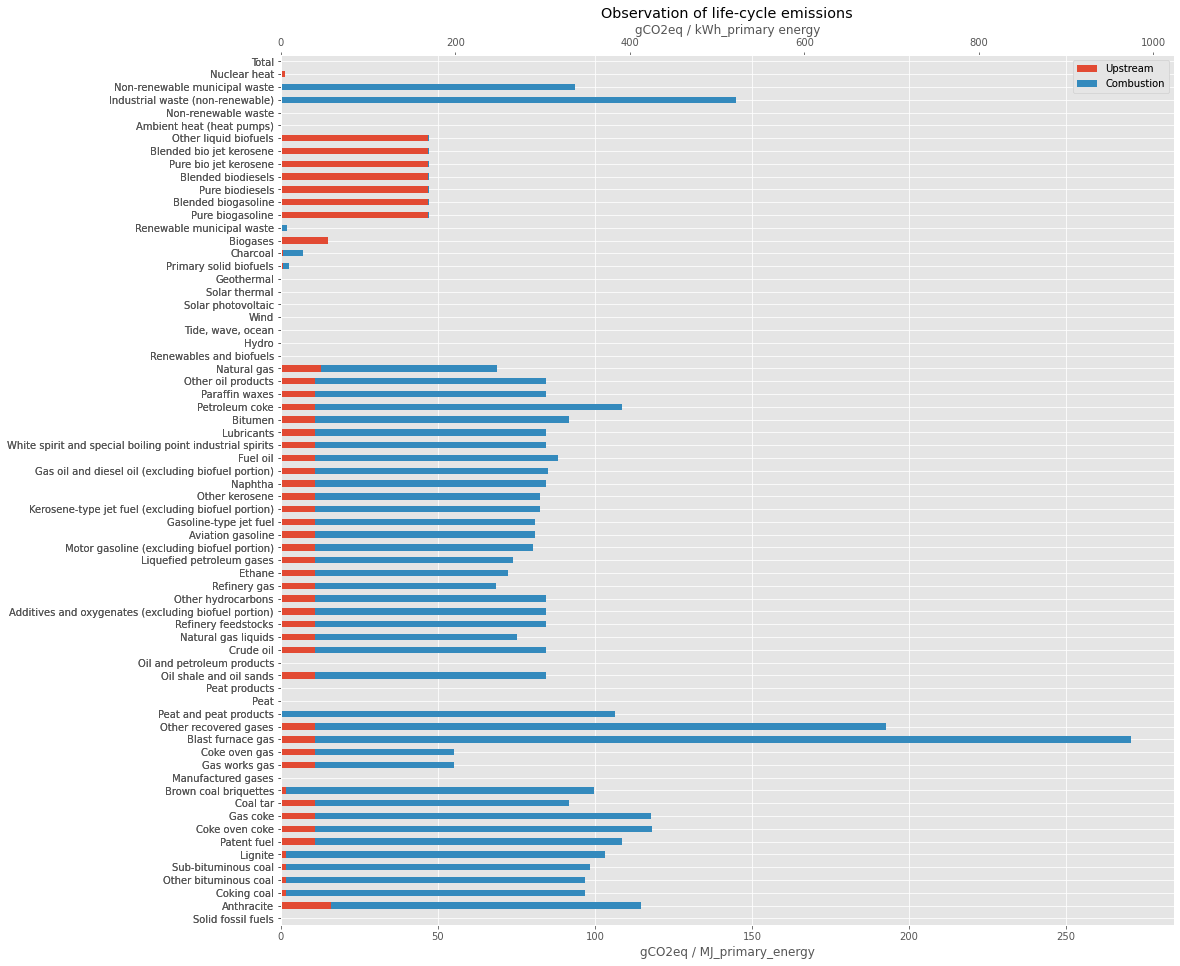

In [18]:
dfp = pd.DataFrame()
dfp["Upstream"] = df_fuels["kg CO2eq / TJ"]["UpstreamE3"]
dfp["Combustion"] = df_fuels["kg CO2eq / TJ (combustion)"]["Total"]

fig, ax = plt.subplots(figsize=(16, 16))
ax2 = ax.twiny()
(dfp * 1e3 / 1e6).plot(ax=ax, kind="barh", stacked=True)
(dfp / 1e6 * 3.6 * 1e3).plot(ax=ax2, kind="barh", stacked=True)
ax.set_title("Observation of life-cycle emissions")
ax.set_xlabel("gCO2eq / MJ_primary_energy")
ax2.set_xlabel("gCO2eq / kWh_primary energy")
ax2.grid(False)

# 2. Gross energy production per pathway for electricity production


Getting eurostat data from https://ec.europa.eu/eurostat/databrowser/view/nrg_bal_c/default/table?lang=en and formatting it in a way to be able to calculate emissions.

Choose "Download -> Full dataset -> tsv".

## Data Formating

In [19]:
# Takes around 1 minute to run, need to be run just once
if False:
    # Loading and formating file
    df = pd.read_csv("data/nrg_bal_c.tsv", sep="\t")
    df.columns = [col.strip() for col in df.columns]
    for i, col in enumerate("nrg_bal,siec,unit,geo\\time".split(",")):
        col = col.split("\\t")[0]
        # print(i, col)
        df[col] = df["nrg_bal,siec,unit,geo\\time"].apply(lambda x: x.split(",")[i])
    df = df.drop("nrg_bal,siec,unit,geo\\time", axis=1)
    df = df[df.unit == "TJ"]  # just keep data in TJ
    df = df.replace(": ", np.nan).replace(": z", np.nan)
    df = df.apply(pd.to_numeric, errors="ignore")
    df_eurostat = df.pivot_table(columns=["nrg_bal", "siec", "geo"])

    # Exported formated data in a pickle file
    df_eurostat.to_pickle("data/df_eurostat.pkl")
else:
    df_eurostat = pd.read_pickle("data/df_eurostat.pkl")

In [20]:
# Getting dictionary of eurostat label for energy names and columns
df = pd.read_excel(
    "data/Energy-Balance-Formulas.xlsx",
    sheet_name="CODES CORRESPONDANCE",
    header=1,
    index_col=0,
)

dict_eurostat_energy_name = df.iloc[0:70][
    "New dissemination labels of Eurostat"
].to_dict()
dict_eurostat_energy_columns = df.iloc[77:-1][
    "New dissemination labels of Eurostat"
].to_dict()

dict_eurostat_energy_name_inv = {
    v.split(" (")[0]: k for k, v in dict_eurostat_energy_name.items()
}
dict_eurostat_energy_columns_inv = {
    v: k for k, v in dict_eurostat_energy_columns.items()
}

# List of useful columns
list_nrg_bal = [
    "GHP_APCHP",
    "GHP_MAPCHP",
    "TI_EHG_APCHP_E",
    "TI_EHG_APE_E",
    "TI_EHG_MAPCHP_E",
    "TI_EHG_MAPE_E",
]

# Printing matching full name
for nrg in list_nrg_bal:
    print(f"{nrg} : {dict_eurostat_energy_columns[nrg]}")

GHP_APCHP : Gross heat production - autoproducer combined heat and power
GHP_MAPCHP : Gross heat production - main activity producer combined heat and power
TI_EHG_APCHP_E : Transformation input - electricity and heat generation - autoproducer combined heat and power - energy use
TI_EHG_APE_E : Transformation input - electricity and heat generation - autoproducer electricity only - energy use
TI_EHG_MAPCHP_E : Transformation input - electricity and heat generation - main activity producer combined heat and power - energy use
TI_EHG_MAPE_E : Transformation input - electricity and heat generation - main activity producer electricity only - energy use


## Calculate Bi (Fuel consumption to produce electricity)

In [21]:
# Sum of main and autoproducer primary fuel input for electricity only
df_input_electricity_only = df_eurostat["TI_EHG_MAPE_E"].add(
    df_eurostat["TI_EHG_APE_E"], axis=1, fill_value=0
)
# Substracting primary fuel input for heat generation (assuming a 85% efficiency) from primary fuel input for CHP
#  - main activity
df_input_CHP_main = df_eurostat["TI_EHG_MAPCHP_E"].sub(
    df_eurostat["GHP_MAPCHP"] / 0.85, fill_value=0
)
#  - autoproducer
df_input_CHP_auto = df_eurostat["TI_EHG_APCHP_E"].sub(
    df_eurostat["GHP_APCHP"] / 0.85, fill_value=0
)
# Sum of main and CHP autoproducer
df_input_CHP = df_input_CHP_main.add(df_input_CHP_auto, fill_value=0)

# Sum of electricity only and CHP
df_Bi = df_input_electricity_only.add(df_input_CHP, fill_value=0)
# transpose and create meaningful indexes
df_Bi = df_Bi.T.unstack()
df_Bi["siec"] = df_Bi.index
df_Bi["siec"] = df_Bi.siec.replace(dict_eurostat_energy_name)
df_Bi.index = df_Bi.siec
df_Bi = df_Bi.drop("siec", axis=1)

## Data observation

Text(0.5, 1.0, 'Gross primary energy for electricity production')

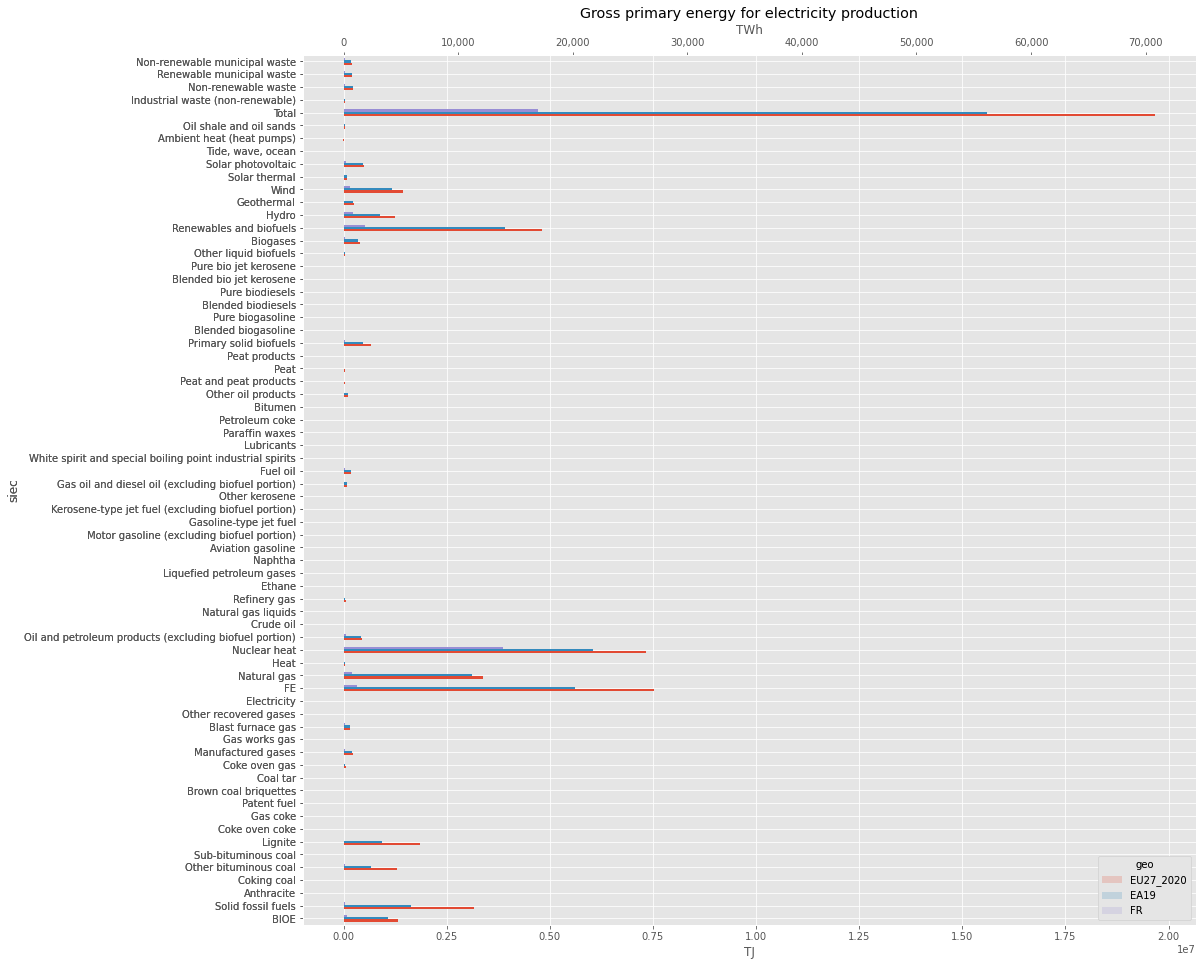

In [22]:
fig, ax = plt.subplots(figsize=(16, 16))
ax2 = ax.twiny()
df_Bi["2020"][["EU27_2020", "EA19", "FR"]].plot(ax=ax, kind="barh")
(df_Bi["2020"][["EU27_2020", "EA19", "FR"]] * 1e6 * 3.6 * 1e-9).plot(
    ax=ax2, kind="barh", alpha=0
)
ax.set_xlabel("TJ")
ax2.set_xlabel("TWh")
ax2.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)
ax2.grid(False)
ax.set_title("Gross primary energy for electricity production")

# 3. Greenhouse gas emissions for the total gross energy production of electricity production

## Data calculation

In [23]:
# Formating dataframes to multiply them using index and columns names
df_Bi.index = [index.split(" (")[0] for index in df_Bi.index]
df_fuels.index = [index.split(" (")[0] for index in df_fuels.index]

common_index = df_Bi.drop(
    ["BIOE", "Electricity", "FE", "Heat"]
).index  # those value do not have emissions factors as they are agregate of categories having emission factors
df_Bi = df_Bi.loc[common_index]
df_fuels = df_fuels.loc[common_index]

# Calculation of greenhouse gas emissions of electricity production (upstream and combustion)
df_GHG_upstream = df_Bi.replace(np.nan, 0).multiply(
    df_fuels["kg CO2eq / TJ"]["UpstreamE3"].dropna(), axis=0
)
df_GHG_combustion = df_Bi.replace(np.nan, 0).multiply(
    df_fuels["kg CO2eq / TJ (combustion)"].Total, axis=0
)
# overall = upstream + combustion
df_GHG = df_GHG_upstream.add(df_GHG_combustion, fill_value=0)
# transpose and create right indices for all
df_GHG = df_GHG.stack().T.swaplevel(0, 1, axis=1)
df_GHG_upstream = df_GHG_upstream.stack().T.swaplevel(0, 1, axis=1)
df_GHG_combustion = df_GHG_combustion.stack().T.swaplevel(0, 1, axis=1)

In [24]:
# Correspondance between country code and country name
import pycountry

list_country = df_GHG.columns.get_level_values(0).unique()
list_country = [
    country for country in list_country if country not in ["EU27_2020", "EA19"]
]

dict_countries = {}

for country_code in list_country:
    # print(country_code)
    if country_code == "FRM":
        country_name = "France Metropolitaine"
    if country_code == "EL":
        country_name = "Greece"
    elif country_code == "UK":
        country_name = "United Kingdom"
    elif country_code == "XK":
        country_name = "Kosovo"
    else:
        COUNTRY = pycountry.countries.get(alpha_2=country_code)
        country_name = COUNTRY.name
    # print(f"{country_code}:{country_name}")
    dict_countries[country_code] = country_name
dict_countries["EU27_2020"] = "European Union - 27 countries (from 2020)"
dict_countries["EA19"] = "Euro area - 19 countries (2015-2022)"

## Data observation

Text(0.5, 1.0, 'GHG emissions of gross energy production for electricity production 2020 (only for fuels that have emissions)')

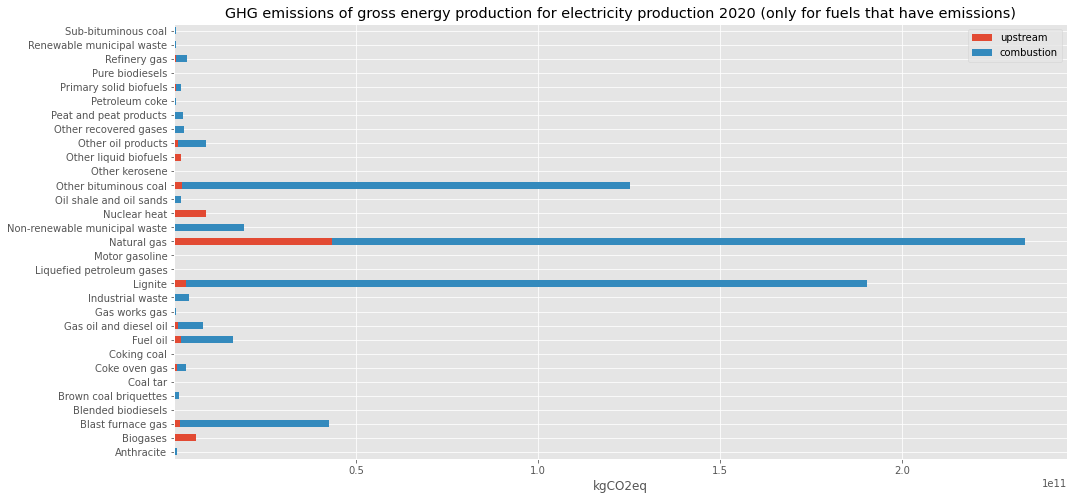

In [25]:
fig, ax = plt.subplots(figsize=(16, 8))
df_GHG_stacked = pd.concat(
    [df_GHG_upstream["EU27_2020"].loc["2020"],
     df_GHG_combustion["EU27_2020"].loc["2020"]], keys=["upstream", "combustion"], axis=1
)
df_GHG_stacked[df_GHG_stacked.sum(axis=1) > 0].plot(ax=ax, kind="barh", stacked=True)
ax.set_xlabel("kgCO2eq")
ax.set_title("GHG emissions of gross energy production for electricity production 2020 (only for fuels that have emissions)")

<ipython-input-26-4de1c77b62f0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df < 0] = 0  # some negative values (to compensate previously over estimated value ?)
<ipython-input-26-4de1c77b62f0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df < 0] = 0  # some negative values (to compensate previously over estimated value ?)


Text(0.5, 1.0, 'GHG emissions of gross energy production for electricity production: upstream + combustion part')

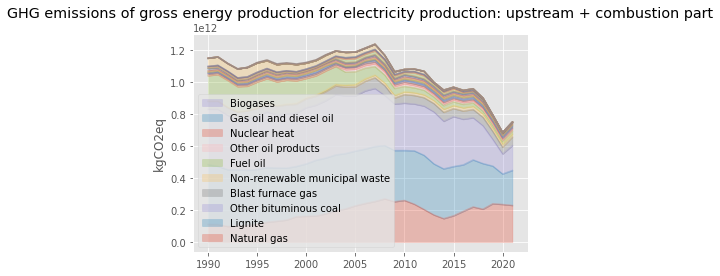

In [26]:
fig, ax = plt.subplots()
df = df_GHG["EU27_2020"]
df[df < 0] = 0  # some negative values (to compensate previously over estimated value ?)
df = df.sort_values("2020", axis=1, ascending=False)
# exclude fuels with no emissions
df = df.loc[:, df.sum() > 1]
df.plot(ax=ax, kind="area", alpha=0.3)
# only display first 10 fuels with highest emissions (and nicely order them)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:10][::-1], list(df.columns[:10])[::-1])
ax.set_ylabel("kgCO2eq")
ax.set_title(
    "GHG emissions of gross energy production for electricity production: upstream + combustion part"
)

# 4. Net electricity production

## Data calculation

In [27]:
# List of useful columns
list_nrg_bal = [
    "TI_EHG_EPS",
    "TO_EHG_PH",
    "NRG_EHG_E",
    "GEP",
    "TO_EHG",
]

# Printing matching full name
for nrg in list_nrg_bal:
    print(f"{nrg}: {dict_eurostat_energy_columns[nrg]}")

TI_EHG_EPS: Transformation input - electricity and heat generation - electricity for pumped storage
TO_EHG_PH: Transformation output - electricity and heat generation - pumped hydro
NRG_EHG_E: Energy sector - electricity and heat generation - energy use
GEP: Gross electricity production
TO_EHG: Transformation output - electricity and heat generation


In [28]:
# Cleaning data (NaN = 0)
df_eurostat = df_eurostat.replace(np.nan, 0)
# no need to substract TO_EHG_PH as it is already included in the gross electricity production (GEP) or TO_EHG
df_E_pump = df_eurostat["TI_EHG_EPS"]  
df_E_own = df_eurostat["NRG_EHG_E"]

# Taking only electricity columns (E7000) instead of total
df_E_own_without_total = df_E_own.drop("TOTAL", axis=1, level=0)
df_E_own_total = pd.concat(
    [df_E_own["E7000"]], axis=1, keys=["TOTAL"]
)
df_E_own = pd.concat(
    [df_E_own_without_total, df_E_own_total], axis=1
)
df_E_gross = df_eurostat["GEP"]  # also corresponds to TO_EHG
# net = gross - own - pump
df_E_net = df_E_gross.sub(df_E_own, fill_value=0).sub(
    df_E_pump, fill_value=0
)
df_E_net = df_E_net.replace(np.nan, 0)
df_E_net = df_E_net.rename(columns=dict_eurostat_energy_name)
# df_eurostat_E_net = df_eurostat_E_net.swaplevel(0, 1, axis=1)
# df_eurostat_E_net = df_eurostat_E_net.rename(columns=dict_countries)

## Data observation

In [29]:
df_E_net.head()

siec BIOE                                                                      \
geo    AL        AT   BA        BE      BG   CY        CZ        DE        DK   
1990  0.0  3783.827  0.0   950.972   0.000  0.0     0.000  5257.461   628.843   
1991  0.0  4048.918  0.0  1004.561   0.000  0.0     0.000  6186.960   986.974   
1992  0.0  4376.637  0.0   895.390  -8.079  0.0     0.000  6755.189  1380.599   
1993  0.0  4589.322  0.0   822.879 -11.787  0.0   538.149  6493.577  1845.317   
1994  0.0  4056.319  0.0   823.712 -13.873  0.0  1071.191  6832.711  1747.319   

siec             ... Non-renewable municipal waste                             \
geo        EA19  ...                            PT   RO   RS     SE   SI   SK   
1990  39046.252  ...                           0.0  0.0  0.0  223.2  0.0  0.0   
1991  41243.167  ...                           0.0  0.0  0.0  219.6  0.0  0.0   
1992  42225.196  ...                           0.0  0.0  0.0  226.8  0.0  0.0   
1993  45628.728  ...                           0.0  0.0  0.0  234.0  0.0  0.0   
1994  48428.824  ...                           0.0  0.0  0.0  194.4  0.0  0.0   

siec                         
geo    TR   UA      UK   XK  
1990  0.0  0.0   298.8  0.0  
1991  0.0  0.0   316.8  0.0  
1992  0.0  0.0   374.4  0.0  
1993  0.0  0.0   597.6  0.0  
1994  0.0  0.0  1263.6  0.0  

[5 rows x 2856 columns]

Text(0.5, 1.0, 'Net electricity production (gross EU27 in red)')

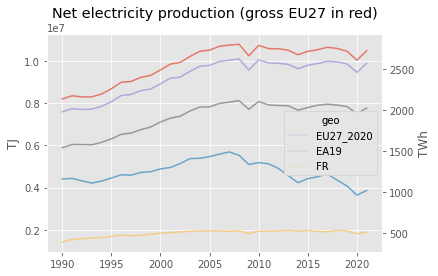

In [30]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
df_E_gross["TOTAL"]["EU27_2020"].plot(
    ax=ax, kind="line", stacked=False, alpha=0.7, label="Gross"
)
df_E_net[df_E_net.columns.intersection([(x, "EU27_2020") for x in fossil_labels])].sum(axis=1).plot(
    ax=ax, kind="line", stacked=False, alpha=0.7, label="Gross"
)
df_E_net["Total"][["EU27_2020", "EA19", "FR"]].plot(
    ax=ax, kind="line", stacked=False, alpha=0.7
)
(df_E_net["Total"][["EU27_2020", "EA19", "FR"]] * 1e6 / 3.6 / 1e9).plot(
    ax=ax2, kind="line", stacked=False, alpha=0
)
ax.set_ylabel("TJ")
ax2.set_ylabel("TWh")
ax2.grid(False)
ax.set_title("Net electricity production (gross EU27 in red)")

# 5. Carbon intensity of electricity production

In [31]:
# Carbon intensity = GHG / E_net
df_CI = df_GHG.sum(level=0, axis=1).divide(df_E_net.Total, axis=0)

# The following can be used to calculate the fossil carbon intensity (of the EU)
# df_E_net_fossil = df_E_net[df_E_net.columns.intersection([(x, "EU27_2020") for x in fossil_labels])].sum(axis=1)
# df_GHG_fossil = df_GHG[df_GHG.columns.intersection([("EU27_2020", x) for x in fossil_labels])].sum(axis=1)
# df_CI_fossil = df_GHG_fossil.divide(df_E_net_fossil)
# df_CI_fossil

<ipython-input-31-2edcbb019abb>:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_CI = df_GHG.sum(level=0, axis=1).divide(df_E_net.Total, axis=0)


## Data observation

In [32]:
df_CI = pd.read_pickle("data/df_CI.pkl")
df_CI.tail()

geo,AL,AT,BA,BE,BG,CY,CZ,DE,DK,EA19,...,PT,RO,RS,SE,SI,SK,TR,UA,UK,XK
2017,0.0,51569.498110,266775.498313,58486.664947,162233.946249,217172.782921,159066.989622,130576.396634,45188.604649,90823.926833,...,113397.792226,108539.413762,245766.825775,5045.060306,80684.594351,53318.456852,148309.491601,113843.663996,85992.650447,302237.558564
2018,0.0,48552.674145,222618.734443,67623.386359,140329.593629,217558.488454,156997.644001,125847.447305,49001.986560,84632.089395,...,92790.038975,105053.118264,228347.398073,5535.297983,77378.992232,54279.762835,147476.465467,120757.285688,80326.547567,317508.571000
2019,0.0,45151.474620,221713.582487,56930.449453,138512.632486,209471.934047,145879.412058,109296.039105,27466.365030,74274.598431,...,76296.927474,107874.535328,231612.360510,5253.885048,75702.817197,46743.073391,134816.784552,116535.455591,74232.913165,305091.212818
2020,0.0,39531.236626,244244.799882,56595.779947,119272.998615,204476.619568,132476.304261,99222.149355,26953.339107,66463.995137,...,61639.675714,86109.131620,235926.610650,4066.809957,70142.446377,45714.018584,129320.716117,106005.462120,NaN,295109.941463
2021,NaN,43329.590137,NaN,46798.284769,130100.363300,199805.396219,135874.256563,111250.378823,31925.121891,69277.182999,...,51448.245491,85625.719357,NaN,4430.657100,69492.147590,47602.053169,NaN,NaN,NaN,NaN


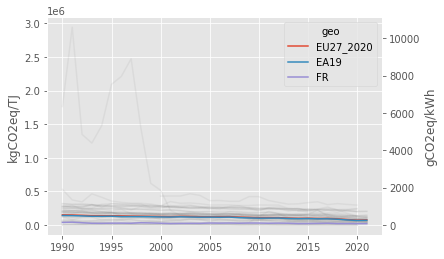

In [33]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
df_CI.plot(ax=ax, color="gray", alpha=0.1, legend=False)
(df_CI * 1e3 / 1e6 * 3.6).plot(ax=ax2, alpha=0, legend=False)
df_CI[["EU27_2020", "EA19", "FR"]].plot(ax=ax)
ax.set_ylabel("kgCO2eq/TJ")
ax2.set_ylabel("gCO2eq/kWh")
ax2.grid(False)

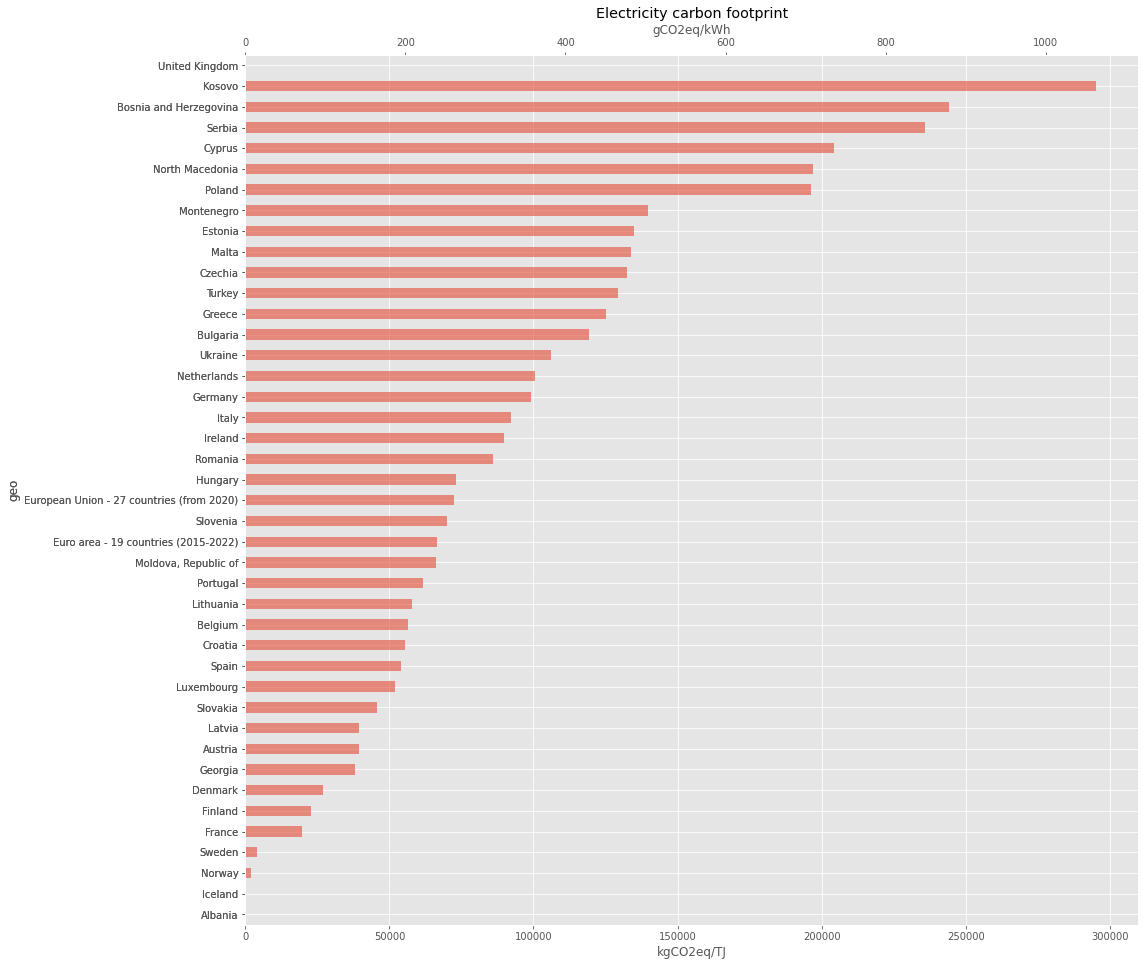

In [34]:
fig, ax = plt.subplots(figsize=(16, 16))
ax2 = ax.twiny()
df_CI.T.rename(dict_countries).T.loc["2020"].sort_values().plot(
    ax=ax, kind="barh", alpha=0.6
)
(df_CI.T.rename(dict_countries).T.loc["2020"].sort_values() * 1e3 / 1e6 * 3.6).plot(
    ax=ax2, kind="barh", alpha=0
)
ax.set_title("Electricity carbon footprint")
ax.set_xlabel("kgCO2eq/TJ")
ax2.set_xlabel("gCO2eq/kWh")
ax2.grid(False)

# 6. Final interactive visualisation

In [62]:
from dash import Dash, dash_table, dcc, html
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc

# conversion factors: multiply dataframes by this value to obtain named unit
elec_units = {"TJ": 1, "GJ": 1e3, "MJ": 1e6, "TWh": 1 / 3600, "MWh": 1 / 3.6}
emissions_units = {"kg CO2eq": 1, "Mt CO2eq": 1 / 1e9, "g CO2eq": 1e3}
ci_units = {"g CO2eq/MJ": 1e-3, "g CO2eq/kWh": 1e-3 * 3.6}

def figure_template(data_x, data_y, type='bar', axis_title_x='', axis_title_y='', title=''):
    return {
        'data': [
            {
                'x': data_x,
                'y': data_y,
                'type': type,
            }
        ],
        'layout': {
            'title': title,
            'xaxis': {
                'automargin': True,
                'title': {'text': axis_title_x}
                },
            'yaxis': {
                'automargin': True,
                'title': {'text': axis_title_y}
            },
            'height': 250,
            'margin': {'t': 10, 'l': 10, 'r': 10},
        },
    }

app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP, dbc.icons.FONT_AWESOME])

unit_card = dbc.Card([
    dbc.CardHeader("Select units"),
    dbc.CardBody([
        dcc.Dropdown(list(elec_units.keys()), "TJ", id='elec-units-select'),
        dcc.Dropdown(list(emissions_units.keys()), "Mt CO2eq", id='emissions-units-select'),
        dcc.Dropdown(list(ci_units.keys()), "g CO2eq/kWh", id='ci-units-select'),
    ])
]) 

temporal_card = dbc.Card([
    dbc.CardHeader(
        "Country time series"
    ),
    dbc.CardBody([
        dcc.Dropdown(df_CI.columns, 'EU27_2020', id='country-select'),
        html.Div(id='temporal-graph-container')
    ])
])


row = html.Div(
    [
        dbc.Row([
            dbc.Col(unit_card, width=2),
            dbc.Col(temporal_card, width=5),
            dbc.Col(html.Div("One of two columns"), width=5)
        ], style={"margin": '8px'})
    ]
)

app.layout = row


@app.callback(
    Output('temporal-graph-container', 'children'),
    Input('country-select', 'value'),
    Input('ci-units-select', 'value'),)
def update_graphs(country_select_value, ci_select_value):
    
    country_selected = country_select_value if country_select_value else 'EU27_2020'

    return [dcc.Graph(
            id=country_selected + '--temporal-chart',
            figure = figure_template(x=df_CI.index, y=df_CI[country_selected] * ci_units[ci_select_value], axis_title_y=ci_select_value, title="Electricity carbon intensity - " + country_selected)
        ),
           ]

#df_E_net.loc(axis=1)[:, ["AT"]]

if __name__ == '__main__':
    app.run_server(port=8051)

Dash is running on http://127.0.0.1:8051/

Dash is running on http://127.0.0.1:8051/

Dash is running on http://127.0.0.1:8051/

Dash is running on http://127.0.0.1:8051/

Dash is running on http://127.0.0.1:8051/

Dash is running on http://127.0.0.1:8051/

Dash is running on http://127.0.0.1:8051/

Dash is running on http://127.0.0.1:8051/

Dash is running on http://127.0.0.1:8051/

Dash is running on http://127.0.0.1:8051/

Dash is running on http://127.0.0.1:8051/

Dash is running on http://127.0.0.1:8051/

Dash is running on http://127.0.0.1:8051/

Dash is running on http://127.0.0.1:8051/

Dash is running on http://127.0.0.1:8051/

Dash is running on http://127.0.0.1:8051/

Dash is running on http://127.0.0.1:8051/

Dash is running on http://127.0.0.1:8051/

 * Serving Flask app '__main__'
 * Debug mode: off


In [ ]:
df_CI = pd.read_pickle("data/df_CI.pkl")
dfp = df_CI.T.rename(dict_countries).T * 1e3 / 1e6
dfp.index = pd.to_datetime(dfp.index, format="%Y")
dfp.head()

geo,Albania,Austria,Bosnia and Herzegovina,Belgium,Bulgaria,Cyprus,Czechia,Germany,Denmark,Euro area - 19 countries (2015-2022),...,Portugal,Romania,Serbia,Sweden,Slovenia,Slovakia,Turkey,Ukraine,United Kingdom,Kosovo
1990-01-01,47.996585,78.228754,NaN,114.109750,204.702706,277.867428,246.494781,199.111662,204.987469,140.466988,...,165.024324,268.221004,287.408824,4.936592,140.190280,137.071356,190.083839,221.282425,214.371346,NaN
1991-01-01,26.037834,80.148696,NaN,112.589000,207.017995,273.770250,244.357777,202.369663,210.446954,138.513478,...,167.317946,289.190125,260.943459,7.263701,111.897683,141.180323,183.869666,210.133683,209.511962,NaN
1992-01-01,16.456285,63.704532,NaN,109.281969,224.087660,284.056176,243.023583,191.659325,201.739063,133.996264,...,203.022277,236.850712,273.477760,7.050344,131.342224,132.837458,180.317447,212.949799,206.679501,NaN
1993-01-01,27.675030,59.311508,NaN,113.926054,219.333696,282.997426,244.281928,191.593033,190.769796,128.480886,...,174.695877,231.985764,300.206162,7.546149,137.974772,134.492572,162.126177,215.606742,183.682379,NaN
1994-01-01,30.853974,65.481524,NaN,120.043655,197.555964,283.277725,247.005533,191.020222,192.136171,128.151272,...,156.640919,231.318606,262.770265,9.256561,117.297959,114.742360,177.010605,194.739548,173.681139,NaN


In [ ]:
bokeh.plotting.output_file("plot/Electricity_carbon_intensity.html")

p = bokeh.plotting.figure(
    width=1200,
    height=500,
    x_axis_type="datetime",
)

p.title.text = f"Evolution of electricity carbon footprint of european countries"

x_data = dfp.index

for i, colp in enumerate(dfp.columns[0:]):
    color = bokeh.palettes.Spectral10[i % 10]
    y_data = dfp[colp].values
    if "Euro" in colp:
        muted = False
    else:
        muted = True
    p.line(
        x_data,
        y_data,
        line_width=2,
        alpha=1,
        color=color,
        muted_color=color,
        muted_alpha=0.05,
        muted_line_width=1,
        legend_label=str(colp),
        muted=muted,
    )

# Legend formating
p.legend.visible = False
n = 14
leg1 = bokeh.models.Legend(items=p.legend.items[0 : 1 * n])
leg2 = bokeh.models.Legend(items=p.legend.items[1 * n : 2 * n])
leg3 = bokeh.models.Legend(items=p.legend.items[2 * n :])
p.add_layout(leg1, "below")
p.add_layout(leg2, "below")
p.add_layout(leg3, "below")
p.legend.orientation = "horizontal"
p.legend.click_policy = "mute"
p.legend.label_text_font_size = "7pt"
# p.legend.location = "top_right"
p.legend.glyph_height = 10
p.legend.glyph_width = 10

p.y_range = bokeh.models.ranges.Range1d(0, 500)
p.yaxis.axis_label = f"gCO2eq/MJ"
p.extra_y_ranges = {"gCO2eq/kWh": bokeh.models.ranges.Range1d(0, 500 * 3.6)}
p.add_layout(
    bokeh.models.LinearAxis(y_range_name="gCO2eq/kWh", axis_label="gCO2eq/kWh"), "right"
)

# Hover
tooltip1 = [("Time", "$x{%F}"), ("Value (gCO2eq/MJe)", "$y{int}")]
p.add_tools(
    bokeh.models.HoverTool(
        show_arrow=False,
        line_policy="next",
        tooltips=tooltip1,
        formatters={"$x": "datetime"},
    )
)

bokeh.plotting.show(p)
bokeh.plotting.save(p)

'p:\\JRC\\11_Review_Oliver_Code\\plot\\Electricity_carbon_intensity.html'

# 7. Graph for country analysis

## Function

In [ ]:
# List with renewable energies grouped under Renewables and biofuels
list_energies_1 = [
    "Solid fossil fuels",
    "Manufactured gases",
    "Peat and peat products",
    "Oil shale and oil sands",
    "Oil and petroleum products",  # "Oil and petroleum products (excluding biofuel portion)",
    "Natural gas",
    "Renewables and biofuels",
    "Non-renewable waste",
    "Nuclear heat",
    "Heat",
    "Electricity",
]

# List of renewable energies
list_renewable_energies = [
    "Hydro",
    "Tide, wave, ocean",
    "Wind",
    "Solar photovoltaic",
    "Solar thermal",
    "Geothermal",
    "Primary solid biofuels",
    "Charcoal",
    "Biogases",
    "Renewable municipal waste",
    "Pure biogasoline",
    "Blended biogasoline",
    "Pure biodiesels",
    "Blended biodiesels",
    "Pure bio jet kerosene",
    "Blended bio jet kerosene",
    "Other liquid biofuels",
    # "Ambient heat",  # "Ambient heat (heat pumps)"
]

# Creation of a list will all energies ungrouped
list_energies_2 = list_energies_1.copy()
list_energies_2.remove("Renewables and biofuels")
list_energies_2 += list_renewable_energies

In [ ]:
# List of summed columns to get total per branch
renewable_and_biofuels = "Renewables and biofuels"
list_renewable_and_biofuels = [
    "Hydro",
    "Tide, wave, ocean",
    "Wind",
    "Solar photovoltaic",
    "Solar thermal",
    "Geothermal",
    "Primary solid biofuels",
    # "Charcoal",
    "Biogases",
    "Renewable municipal waste",
    "Pure biogasoline",
    "Blended biogasoline",
    "Pure biodiesels",
    "Blended biodiesels",
    "Pure bio jet kerosene",
    "Blended bio jet kerosene",
    "Other liquid biofuels",
    "Ambient heat",
]
non_renewable_waste = "Non-renewable waste"
list_on_renewable_waste = ["Industrial waste", "Non-renewable municipal waste"]
oil_and_petroleum = "Oil and petroleum products"
list_oil_and_petroleum = [
    "Crude oil",
    "Natural gas liquids",
    # "Refinery feedstocks",
    # "Additives and oxygenates",
    # "Other hydrocarbons",
    "Refinery gas",
    "Ethane",
    "Liquefied petroleum gases",
    "Motor gasoline",
    "Aviation gasoline",
    "Gasoline-type jet fuel",
    "Kerosene-type jet fuel",
    "Other kerosene",
    "Naphtha",
    "Gas oil and diesel oil",
    "Fuel oil",
    "White spirit and special boiling point industrial spirits",
    "Lubricants",
    "Bitumen",
    "Petroleum coke",
    "Paraffin waxes",
    "Other oil products",
]
peat = "Peat and peat products"
list_peat = ["Peat", "Peat products"]
manufactured_gas = "Manufactured gases"
list_manufactured_gas = [
    "Coke oven gas",
    "Gas works gas",
    "Blast furnace gas",
    "Other recovered gases",
]
solid_fossil_fuels = "Solid fossil fuels"
list_solid_fossil_fuels = [
    "Anthracite",
    "Coking coal",
    "Other bituminous coal",
    "Sub-bituminous coal",
    "Lignite",
    "Patent fuel",
    "Coke oven coke",
    "Gas coke",
    "Coal tar",
    "Brown coal briquettes",
]

dict_subtotal = {
    renewable_and_biofuels: list_renewable_and_biofuels,
    non_renewable_waste: list_on_renewable_waste,
    oil_and_petroleum: list_oil_and_petroleum,
    peat: list_peat,
    manufactured_gas: list_manufactured_gas,
    solid_fossil_fuels: list_solid_fossil_fuels,
}

In [ ]:
# Loading data
df_eurostat_E_net = pd.read_pickle("data/df_eurostat_E_net.pkl")
df_eurostat_E_net = df_eurostat_E_net.swaplevel(0, 1, axis=1)
df_GHG = pd.read_pickle("data/df_GHG.pkl")
df_CI = pd.read_pickle("data/df_CI.pkl")
df_fuels = pd.read_pickle("data/df_fuels.pkl")

In [ ]:
# Plot evolution of the electricity mix
country_code = "FR"
thresold_value = 0.02
year = "2020"

In [ ]:
def generate_graph_country_analysis(
    country_code="FR", thresold_value=0.02, year="2020"
):
    country = dict_countries[country_code]

    # Figure with 4 subfigures
    fig, ax = plt.subplots(2, 2, figsize=(16, 9))

    # First subgraph
    df_country_energy = df_eurostat_E_net[country_code]
    df_country_energy.index = pd.to_datetime(df_country_energy.index)
    df_country_energy.columns = [
        col.split(" (")[0] for col in df_country_energy.columns
    ]

    # Filter energy sources based on their share in the electricity mix
    dfp = (
        df_country_energy[list_energies_2]
        .drop("Electricity", axis=1)
        .drop("Heat", axis=1)
    )
    dfpn = dfp.divide(df_country_energy.Total, axis=0)
    filter_dfp = (dfpn > thresold_value).max()
    major_energies = filter_dfp.replace(False, np.nan).dropna().index
    minor_energies = filter_dfp.replace(True, np.nan).dropna().index

    # Data to be plotted
    dfp = pd.DataFrame()
    dfp = df_country_energy[major_energies]
    dfp["Others"] = df_country_energy[minor_energies].sum(axis=1)

    ax00 = ax[0][0]
    ax00b = ax00.twinx()
    dfp[dfp < 0] = 0  # Filtering some negative values
    dfp.plot(ax=ax00, kind="area", stacked=True, alpha=0.3, legend="reverse")
    (dfp * 1e6 / 3.6 * 1e-9).plot(
        ax=ax00b, kind="area", stacked=True, alpha=0.0, legend=False
    )
    df_country_energy[["Total"]].plot(ax=ax00, lw=2, color="red")
    ax00.set_title(f"Electricity mix:{country}")
    ax00.set_ylabel("Annual production (TJ)")
    ax00b.set_ylabel("Annual production (TWh)")
    ax00b.grid(False)

    # Second subplot
    # Plot GHG emissions
    df_country_GHG = df_GHG[country_code]
    df_country_GHG.index = pd.to_datetime(df_country_GHG.index)

    # Adding sub-total data
    for column_target in dict_subtotal:
        # print(column_target)
        list_columns = dict_subtotal[column_target]
        df_country_GHG.loc[:, column_target] = df_country_GHG[list_columns].sum(axis=1)

    # Data to be plotted
    dfp = df_country_GHG[major_energies]
    dfp["Others"] = df_country_GHG[minor_energies.drop("Charcoal")].sum(axis=1)
    dfp[dfp < 0] = 0

    ax01 = ax[0][1]
    dfp.plot(ax=ax01, kind="area", alpha=0.3, legend="reverse")
    ax01.set_title(f"GHG emissions of the net electricity production:{country}")
    ax01.set_ylabel("Annual emissions (kgCO2eq)")

    # Third graph

    # Calculating emissions factors, weighted subtotal, total and others as well
    df_fuels = pd.read_pickle("data/df_fuels.pkl")
    dict_subtotal_and_total = dict_subtotal.copy()
    dict_subtotal_and_total["Others"] = minor_energies
    dict_subtotal_and_total["Total"] = list_energies_2
    for column_target in dict_subtotal_and_total:
        # print(column_target)
        list_columns = dict_subtotal_and_total[column_target]
        # display(list_columns)
        list_columns = [col for col in list_columns if col in df_fuels.index]

        df_weight_year_energy_category = df_country_energy[list_columns][year]
        df_weight_year_energy_category = (
            df_weight_year_energy_category
            / df_weight_year_energy_category.sum(axis=1).sum()
        )
        df_weight_year_energy_category = df_weight_year_energy_category.T.squeeze()
        df_fuels_energy_category = df_fuels.loc[list_columns].drop(
            "siec", axis=1, level=1
        )
        df_fuels.loc[column_target] = df_fuels_energy_category.multiply(
            df_weight_year_energy_category, axis=0
        ).sum(axis=0)

    df_fuels_filtered = df_fuels.loc[list(major_energies) + ["Others", "Total"]]

    # DataFrame to be plotted
    dfp = pd.DataFrame()
    dfp["Upstream"] = df_fuels_filtered["kg CO2eq / TJ"]["UpstreamE3"]
    dfp["Combustion"] = df_fuels_filtered["kg CO2eq / TJ (combustion)"]["Total"]

    ax10 = ax[1][0]
    ax10b = ax10.twiny()
    (dfp * 1e3 / 1e6).plot(ax=ax10, kind="barh", stacked=True, alpha=0.6)
    (dfp / 1e6 * 3.6 * 1e3).plot(
        ax=ax10b, kind="barh", stacked=True, alpha=0, legend=False
    )
    ax10.set_title("Observation of upstream and combustion emission")
    ax10.set_xlabel("gCO2eq / MJ_primary_energy")
    ax10b.set_xlabel("gCO2eq / kWh_primary energy")
    ax10b.grid(False)

    # Fourth graph
    ax11 = ax[1][1]
    ax11b = ax11.twinx()
    (df_CI[[country_code]] * 1e3 / 1e6).plot(ax=ax11, kind="area", alpha=0.3)
    (df_CI[[country_code]] * 1e3 / 1e6).plot(
        ax=ax11b, kind="area", alpha=0, legend=False
    )
    (df_CI[["EU27_2020", "EA19"]] * 1e3 / 1e6).plot(ax=ax11)
    (df_CI[["EU27_2020", "EA19"]] * 1e3 / 1e6 * 3.6).plot(
        ax=ax11b, alpha=0, legend=False
    )
    (df_CI * 1e3 / 1e6).plot(ax=ax11, alpha=0.05, legend=False, color="grey")
    (df_CI * 1e3 / 1e6 * 3.6).plot(ax=ax11b, alpha=0.0, legend=False, color="grey")

    ax11.set_ylabel("gCO2eq/MJe")
    ax11b.set_ylabel("gCO2eq/kWh")
    ax11b.grid(False)
    ax11.set_title(
        f"Evolution of carbon intensity of net electricity production:{country}"
    )

    plt.tight_layout()
    return fig

## Iteration over countries

In [ ]:
if True:
    for country_code in dict_countries:
        country = dict_countries[country_code]
        print(country)

        fig = generate_graph_country_analysis(
            country_code=country_code, thresold_value=0.02, year="2020"
        )
        fig.savefig(f"plot/{country}.png")
        plt.close("all")

## Country by country

In [ ]:
if False:
    fig = generate_graph_country_analysis(
        country_code="FR", thresold_value=0.02, year="2020"
    )

# Export data

In [ ]:
df_CI = pd.read_pickle("data/df_CI.pkl")
df_CI = df_CI.T.rename(dict_countries)
df_CI.sort_index()
df_CI.to_csv("data/EUROSTAT_carbon_intensity.csv", sep=";", decimal=",")
(df_CI[["2020"]] / 1e3).to_csv(
    "data/EUROSTAT_carbon_intensity_2020_gCO2perMJe.csv",
    sep=";",
    decimal=",",
    float_format="%0.1f",
)